## Section 1 : Generating synthetic data

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from numpy.random import randint
import sys
import os
import warnings
warnings.filterwarnings('ignore')

method = "convolve"  ## options: add or convolve
dataset = "demosim"  ## name of generated datset
nclusters = 4        ## number of clusters in data
ngenes = [20]*nclusters ## 20 genes per cluster 
length = 100         ## 100 timepoints per gene 
x= np.linspace(0,length/1000,length)  ## spanned over a range 0 to 0.1
data = []           ## initialize data list

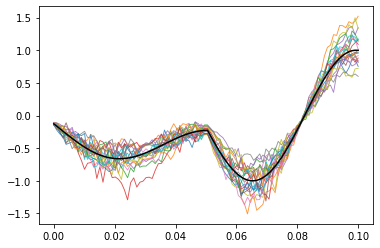

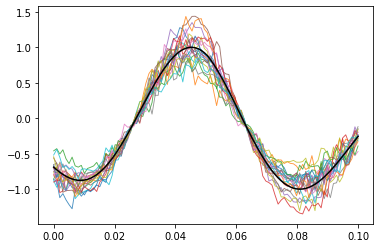

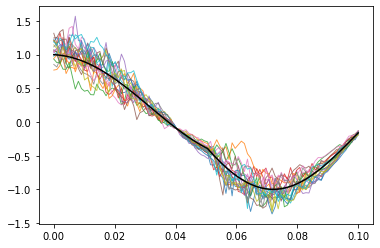

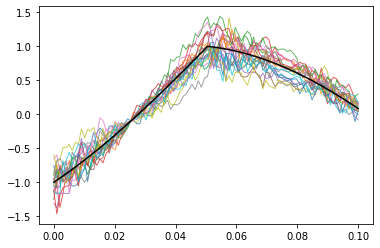

In [18]:
for i in range(nclusters): ### for each cluster 
    if(method == "add"): ## find a mean function by adding a sin and a cos and then scaling 
        y = randint(0,100)*np.sin(randint(0,100)*x)+randint(0,100)*np.cos(randint(0,100)*x) 
        y = MinMaxScaler(feature_range=(-1,1)).fit_transform(y.reshape(-1, 1)).reshape(-1)
    elif(method == "convolve"): ## find a mean function by convolving a sin and a cos and then scaling 
        y = np.convolve(randint(0,100)*np.sin(randint(0,100)*x), randint(0,100)*np.cos(randint(0,100)*x), 'same')
        y = MinMaxScaler(feature_range=(-1,1)).fit_transform(y.reshape(-1, 1)).reshape(-1)
    else:
        print("not implemented")
        sys.exit()
    y_vec = y[:,np.newaxis] + 0.1
    cov = np.dot(y_vec,y_vec.T)/np.dot(y.T,y) ## compute YY^T as covariance
    del(y_vec)
    for m in range(cov.shape[0]):   ## make elements in cov with indices too far (50 chosen here) from each other 0
        for n in range(cov.shape[1]):
            if(abs(m-n) > 50):
                cov[m][n] = 0

    for gene in range(ngenes[i]):   ## sample member genes for each cluster using mean function and cov
        exp = np.random.multivariate_normal(y,cov)
        #exp = exp + np.random.normal(0,0.1,y.shape[0])
        data.append([str(i)] + [str(j) for j in exp.tolist()])
        plt.plot(x,exp,alpha=0.8,linewidth=0.9)
    plt.plot(x,y, color="#000000", label="cluster mean")
    plt.savefig("./figs/cluster_" + dataset + str(i) + ".png", dpi = 500)
    plt.show()
    plt.close()

In [19]:
## write data to proper location
if(not os.path.exists("./data/"+dataset)):
    os.mkdir("./data/"+dataset)
f = open("./data/"+dataset+"/"+dataset+"_TRAIN","w")
f.write("\n".join([",".join(row) for row in data]))
f.close()

f = open("./data/"+dataset+"/"+dataset+"_TEST","w") ## dummy test file (same as train file), modify as needed
f.write("\n".join([",".join(row) for row in data[:2]]))
f.close()

print("generated synthetic data at ./data/" + dataset)
print("true clusters of generated data plotted at ./figs/" + dataset)

generated synthetic data at ./data/demosim
true clusters of generated data plotted at ./figs/demosim


## Section 2: Define and train RVAgene on the generated data

In [20]:
from rvagene.rvagene import RVAgene
from rvagene.utils import open_data
import numpy as np
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import TensorDataset
import sys

### model params ###
hidden_size = 70
hidden_layer_depth = 1
latent_length = 3
batch_size = 20
learning_rate = 0.003
n_epochs = 400
dropout_rate = 0.2
optimizer = 'Adam' # options: ADAM, SGD
cuda = False # options: True, False
print_every=30
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
dataset='demosim'

X_train, _, y_train, _ = open_data('data', ratio_train=1, dataset=dataset)

num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base


train_dataset = TensorDataset(torch.from_numpy(X_train))


sequence_length = X_train.shape[1]
number_of_features = X_train.shape[2]

rvagene = RVAgene(sequence_length=sequence_length,
            number_of_features = number_of_features,
            hidden_size = hidden_size,
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer,
            cuda = cuda,
            print_every=print_every,
            clip=clip,
            max_grad_norm=max_grad_norm,
            loss = loss)

rvagene.fit(train_dataset)

...

## Section 3: Perform unsupervised K-means clustering on latent space

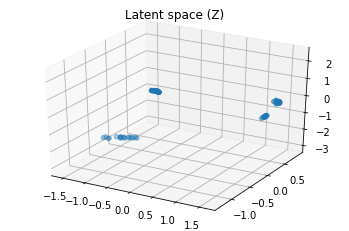

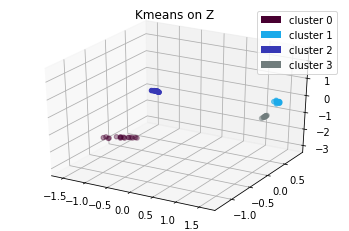

In [21]:
%matplotlib inline
z_run = rvagene.transform(train_dataset)  ## latent embeddings of training genes

############### plot 3 dimensional z plot ##################
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

ax1.scatter(z_run[:,0],z_run[:,1],z_run[:,2])
plt.title("Latent space (Z)")
plt.savefig("figs/z_run_"+dataset+".png", dpi=500)
plt.show()
plt.close()

################## k means clustering on z ################
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=4,
                         random_state=0,
                         batch_size=6,
                         max_iter=10).fit(z_run)

centers = kmeans.cluster_centers_

c_zs = kmeans.predict(z_run)
legend = dict()
hex_colors = []
counts = dict()

################## plot 3 D z with kmeans clustering ##############
for i in np.unique(c_zs):
    hex_colors.append('#%06X' % np.random.randint(0, 0xFFFFFF))
    legend[i]=hex_colors[-1]
colors = [hex_colors[int(i)] for i in c_zs]
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

ax1.scatter(z_run[:,0],z_run[:,1],z_run[:,2],c=colors)

legend_elements = [Patch(facecolor=legend[i],
                         label="cluster "+str(i) ) for i in legend.keys() ]
ax1.legend(handles=legend_elements)
plt.title("Kmeans on Z")
plt.savefig("figs/clusters_"+dataset+".png", dpi=500)
plt.show()
plt.close()

## Section 4:  New cluster specific gene expression time-series data generation

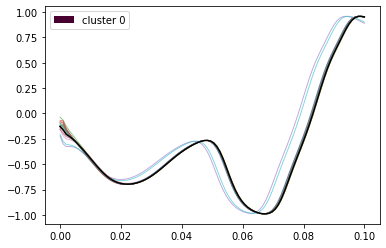

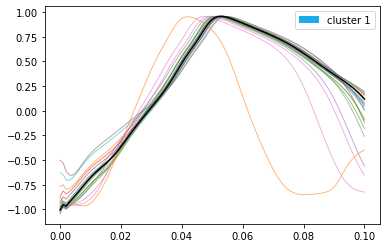

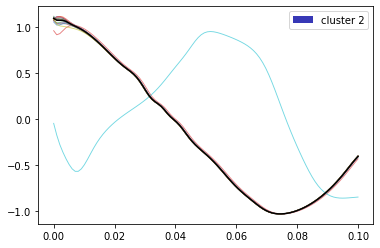

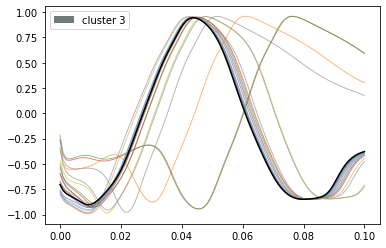

In [22]:
#################### sample points from Z around each cluster mean detected by K-means, decode and plot those points #################
samples_per_cluster = 20


length = sequence_length
x= np.linspace(0,length/1000,length)

for i in range(centers.shape[0]): ## for each cluster center
    mean = centers[i]
    cov = np.identity(centers[i].shape[0]).astype(np.double)*0.3 ## define gaussian around it to sample from

    samples = []
    for gene in range(samples_per_cluster): ## sample points from Z  
        sample = np.random.multivariate_normal(mean,cov).astype(np.double)
        samples.append(sample)
        #print("sample ",gene,"for cluster ", i,": ",sample)
    torch_samples = torch.from_numpy(np.array(samples)).float()

    mean_to_torch = torch.from_numpy(np.array([mean]*samples_per_cluster)).float()
    if torch.cuda.is_available():
        dev = "cuda:0"
    else:
        dev = "cpu"
    device = torch.device(dev)
    torch_samples = torch_samples.to(device)
    mean_to_torch = mean_to_torch.to(device)
    device = torch.device("cpu")
    ### decode sampled point from  Z to get new generated data
    regen = np.squeeze((rvagene.decoder.forward(torch_samples)).to(device).data.numpy())
    mean_regen = np.squeeze((rvagene.decoder.forward(mean_to_torch)).to(device).data.numpy())

    ############### plot decoded cluster means ##############
    for gene in range(samples_per_cluster):
        plt.plot(x,regen[:,gene],alpha=0.6,linewidth=0.9)
    plt.plot(x,mean_regen[:,0],color="#000000")
    plt.legend(handles=[legend_elements[i]])
    plt.savefig("figs/generated_cluster_" + dataset + str(i) + ".png", dpi=500)
    plt.show()
    plt.close()